<a href="https://colab.research.google.com/github/rctn/sparsecoding/blob/harrison%2Fnew_notebook/examples/Intro_To_Sparse_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to show how sparsecoding can be used in an applied way.

In [1]:
!git clone https://github.com/rctn/sparsecoding.git
%cd /content/sparsecoding
import os
os.environ['PYTHONPATH'] = f"/content/sparsecoding:{os.environ.get('PYTHONPATH', '')}"

Cloning into 'sparsecoding'...
remote: Enumerating objects: 1676, done.
remote: Counting objects: 100% (667/667), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 1676 (delta 417), reused 443 (delta 353), pack-reused 1009 (from 1)
Receiving objects: 100% (1676/1676), 28.68 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (922/922), done.
/content/sparsecoding


# Setup

Run the following cells for some visualization functions

In [84]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
import jax.numpy as jnp
import jax
import numpy as np
import time


def load_dataset(data_dir='../../imgs', batch_size=32, color = True):

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1) if not color else transforms.Lambda(lambda x: x)
    ])

    download = not os.path.exists(data_dir)

    full_dataset = datasets.Imagenette(
        root=data_dir,
        download=download,
        transform=transform
    )

    loader = DataLoader(
        full_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )

    return loader


def display_images(imgs, title = None):

    is_grayscale = imgs.shape[1] == 1
    fig, axes = plt.subplots(1, 4, figsize=(8, 4))

    for i in range(4):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        if is_grayscale:
            img = img.squeeze()
        axes[i].imshow(img, cmap='gray' if is_grayscale else None)
        axes[i].axis('off')

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

def display_whitened_images(imgs, title = None):

    is_grayscale = imgs.shape[1] == 1

    fig, axes = plt.subplots(1, 4, figsize=(8, 4))

    for i in range(4):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        if is_grayscale:
            img = img.squeeze()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        axes[i].imshow(img, cmap='gray' if is_grayscale else None)
        axes[i].axis('off')

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

def show_patches(patches, title=""):
    """Given patches of images, create a grid and display it.

    patches is a Tensor with shape (batch_size, pixels_per_patch).
    """
    size = int(np.sqrt(patches.size(1)))
    batch_size = patches.size(0)
    img_grid = torch.reshape(patches, (-1, 1, size, size))
    out = make_grid(img_grid, padding=1, nrow=int(
        np.sqrt(batch_size)), pad_value=torch.min(patches))[0]
    display(out, bar=False, title=title)

def display(img, title=None, bar=True, cmap="gray", dpi=150, vrange=None):
    """Display images in Jupyter notebook.

    Parameters
    ----------
    img : Tensor or NumPy array of image values to display.
    title: String; title of figure. Optional.
    bar : Whether to show color bar on the side. Optional; default True.
    cmap : Color map. Optional; default 'gray'.
    dpi : Controls size. Optional; default 150.
    vrange : Tuple (value_min, value_max). Optional (will set automatically).
    """
    plt.axis("off")
    if vrange:
        vmin = vrange[0]
        vmax = vrange[1]
    else:
        vmin = torch.min(img)
        vmax = torch.max(img)
    plt.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
    fig = plt.gcf()
    fig.set_dpi(dpi)
    if bar:
        plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

#Intro and Theory

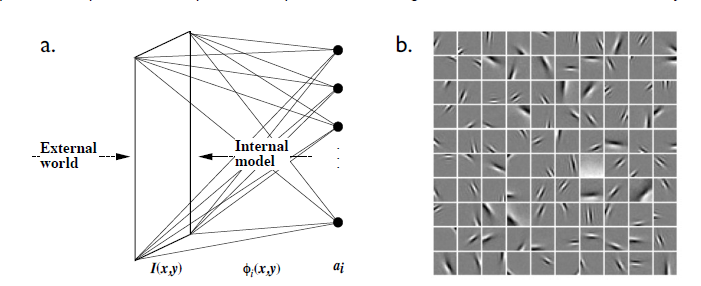

Sparse coding is a computational framework that seeks to represent structured data using a minimal set of active components from an overcomplete basis. In the context of images, it posits that any image (Fig 1.a) can be approximated as a linear combination of basis functions (Fig 1.b) weighted by sparse coefficients More formally, the sparse coding model is of the form
$$ \tag{1} I(x,y) = \sum_i a_i \phi_i (x,y) + \epsilon(x,y)$$
* $I(x,y)$ denotes the pixel intensities within an image patch ($x$ and $y$ are spatial coordinates)
* The $\phi_i(x, y)$ are a set of basis functions, also referred to as a "dictionary" of features for describing the image
* $a_i$ correspond to the neural activity ($i$ denotes the index of the neuron)
* $\epsilon(x,y)$ is an additive noise term, assumed to be Gaussian

We wish to find a dictionary of features that allow images to be described using as few non-zero $a_i$ as possible. This can be stated as two primary goals:
1. Given a batch of images and a dictionary, infer sparse coefficients
2. Learn the dictionary of basis functions


## Energy function
To compute $a_i$ for a given image $I(x,y)$ while learning dictionary $\phi$, we minimize the energy function governing the system:
$$ \tag{2} E=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i \phi_i(x,y)\bigg]^2 + \lambda\sum_i C(a_i)$$
* The first term measures how well information is preserved, or how well the code describes the image, defined using mean squared error between the original image patch and the reconstruction.
* The second term assesses the sparseness of the code for a given image by assigning a cost defined by $C(a_i)$ depending on how activity is distributed among the coefficients. Representations where activity is spread over many coefficients should incur a higher cost than those where only few coefficients carry the load. Below we use $C(x) = |x|$, thus $C'(x) = \text{sign}(x)$.
* $\lambda$ is a positive constant that determines the importance of the second term relative to the first.



# Basic Image Preprocessing
In the sparsecoding model, it is typically assumed that we are working on <i>whitened</i> data. Image whitening (also known as sphering) is a preprocessing technique that transforms a dataset with correlated features into one where the features are uncorrelated and have unit variance.
<br><br>

The primary motivation for image whitening in machine learning and computer vision is to make the learning process more efficient and effective. By decorrelating the features beforehand, we make the learning task easier - each feature becomes independently informative, and the optimization landscape becomes better conditioned.
<br><br>

For more details on how it works and how you can do it with this repo, check out our notebook on whitening.

----



First let's download some images from Imagenette

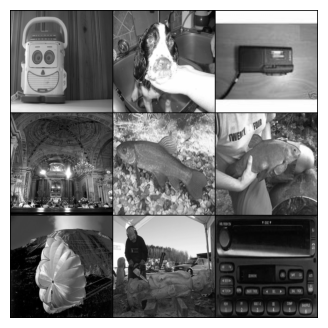

In [3]:
dataloader = load_dataset(color = False, batch_size = 64)
display_random_images(dataloader, n=9)

And now use our repo to whiten them

images.shape=torch.Size([64, 1, 256, 256])


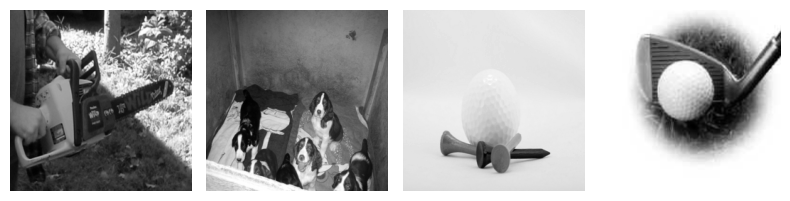

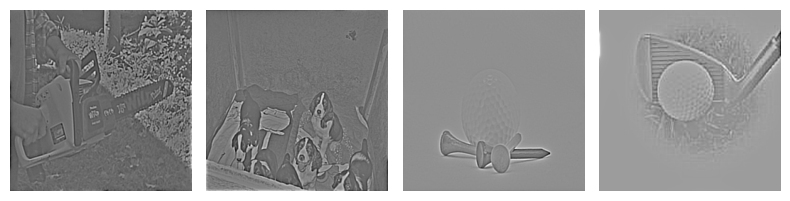

In [86]:
from sparsecoding.transforms import whiten_images

#now whiten and visualize a subset
images, _  = next(iter(dataloader))

whitened_imgs = whiten_images(images, algorithm = 'frequency')
display_images(images)
display_whitened_images(whitened_imgs)

When computing our basis functions, you typically learned on image patches rather than full images for both computational and neuroscientific reasons. First, natural image statistics exhibit strong local spatial correlations, and the underlying generative process is approximately translation invariant. This suggests that optimal basis functions should be localized in space, similar to receptive fields observed in the primary visual cortex (V1). Second, learning on patches is computationally cheap. The dictionary learning optimization scales with the square of the input dimension, making it prohibitive for full-resolution images.
<br><br>

Here, let us sample our images for 100 random patches of size 32x32

patches.shape=torch.Size([100, 1, 32, 32])


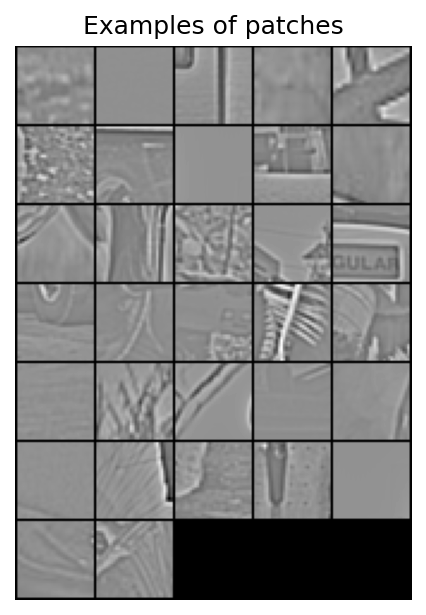

In [89]:
from sparsecoding.transforms import sample_random_patches

n_patches = 100
patch_size = 32
patches = sample_random_patches(image=whitened_imgs, patch_size=patch_size, num_patches=n_patches)
print(f'{patches.shape=}')

# reshape for later use
data = patches.reshape([n_patches, -1])
n_samples, n_features = data.shape
show_patches(data[:32], title="Examples of patches")

# Learning and Patch Reconstruction

Now let's infer our basis patterns. Here we will be using the ISTA method as defined in

[Beck, A., & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems.](https://epubs.siam.org/doi/10.1137/080716542)

We provide the functionality for multiple inference methods, please refer to the documentation for more details.        

In [90]:
from sparsecoding import inference
from sparsecoding import models
from sparsecoding.visualization import plot_dictionary
from sparsecoding.visualization import plot_patches

### DEFINE MODEL
ista = inference.ISTA(n_iter=100, sparsity_penalty=2e-1, stop_early=True)
sc = models.SparseCoding(inference_method=ista,n_basis=n_features,
                         n_features=n_features,dictionary_lr=1e-1)

In [92]:
n_epoch = 10
nrow = 16

# Learn dictionary of basis patterns
for i in range(n_epoch):
    sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    if i % 2 == 0:
        print(f'Epoch {i}')

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='Final Patterns',nrow=nrow)

Epoch 0
Epoch 2
Epoch 4
Epoch 6
Epoch 8


Now that we have these patterns how can we use them? Going back to our model, we have $\phi$, and we need to detemine the coefficients $a$ that approximate $I$. This is made possible through each inference class' `infer()` method. Let's get our coeffecients, and then see how good of a job these patterns do at reconstructing each patch

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'reconstruction (50 of 100)'}>)

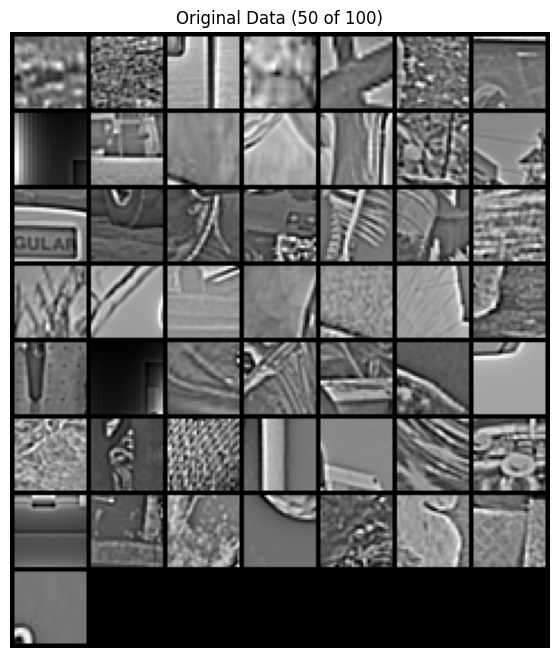

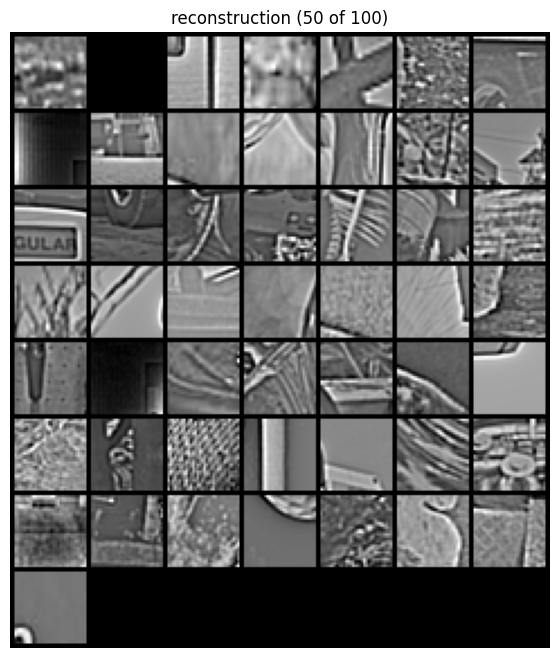

In [94]:
dictionary = torch.tensor(sc.get_numpy_dictionary().astype(np.float32))
a = ista.infer(data, dictionary)
ihat = torch.mm(dictionary, a.T).T
plot_patches(data[:50,:], title="Original Data (50 of {})".format(data.shape[0]))
plot_patches(ihat[:50,:], title="reconstruction (50 of {})".format(data.shape[0]))


And for most of them they look pretty good! Let's verify that our coefficients are indeed sparse (most are zero).

sparsity (total # of 0s/total # coefficients): 0.989853515625


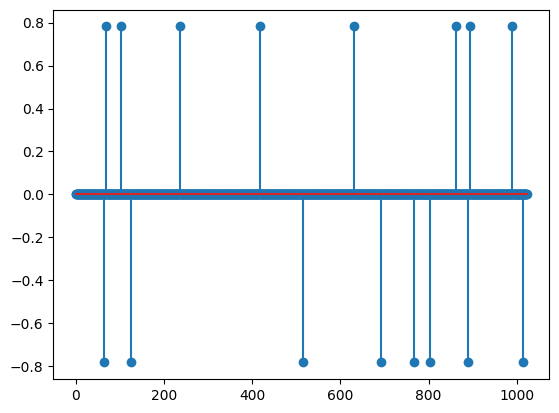

In [96]:
sparsity = np.sum(np.array(a) == 0 * 1)/np.array(a).size
print("sparsity (total # of 0s/total # coefficients): {}".format(sparsity))

plt.stem(a[5])
plt.show()

# Full Image Reconstruction

But a single patch by itself isn't very useful, how can we do this for entire images?

The answer is to break an image down into patches, reconstruct each patch, then stitch all the reconstructions back together.

In [110]:
from sparsecoding.transforms import patchify, quilt

def process_image_with_sparse_coding(images: torch.Tensor, dictionary: torch.Tensor, patch_size: int = 32):
    """
    1. Break image into patches
    2. Infer sparse coefficients for each patch
    3. Reconstruct patches
    4. Reassemble into full image
    """
    holder = []
    for image in images:
      image = image.unsqueeze(0)

      # Get image dimensions
      _, C, H, W = image.shape

      # Break into patches
      patches = patchify(
          patch_size=patch_size,
          image=image,
      )  # Shape: [N, C, P, P]

      # Reshape patches for sparse coding
      num_patches = patches.shape[1]
      flat_patches = patches.reshape(num_patches, -1)

      # Infer sparse coefficients
      a = ista.infer(flat_patches, dictionary)

      # Reconstruct patches
      reconstructed_flat = torch.mm(dictionary, a.T).T
      reconstructed_patches = reconstructed_flat.reshape(num_patches, C, patch_size, patch_size)

      # Reassemble full image
      reconstructed_image = quilt(
          height=H,
          width=W,
          patches=reconstructed_patches
      )

      holder.append(reconstructed_image)

    reconstructed_images = torch.stack(holder)

    return reconstructed_images


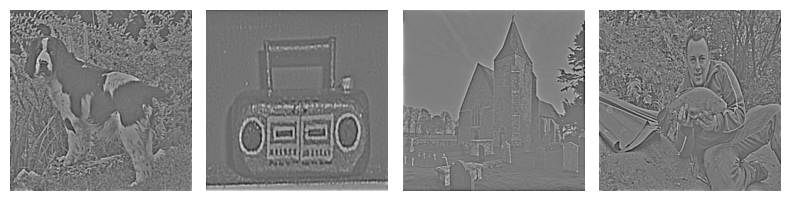

In [107]:
#First let's grab a new set of whitened images. This will be what we break down and reconstruct
images, _  = next(iter(dataloader))
whitened_imgs = whiten_images(images, algorithm = 'frequency')
display_whitened_images(whitened_imgs)

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


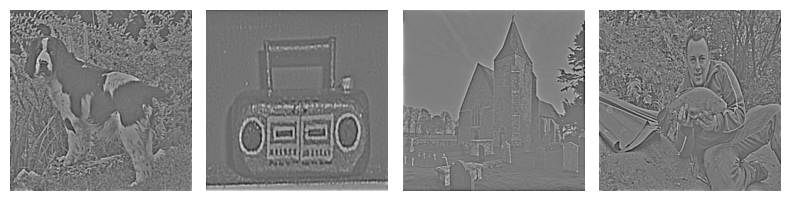

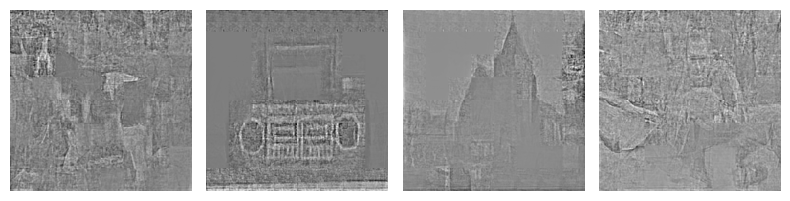

In [111]:
imgs = whitened_imgs[:4]
reconstructed_images = process_image_with_sparse_coding(imgs, dictionary, patch_size=32)

display_whitened_images(imgs)
display_images(reconstructed_images)

What if we try with smaller patches?

In [114]:
# patch size 32 -> 8
patch_size = 8
patches = sample_random_patches(image=whitened_imgs, patch_size=patch_size, num_patches=n_patches)
data = patches.reshape([n_patches, -1])
n_samples, n_features = data.shape

ista = inference.ISTA(n_iter=100, sparsity_penalty=2e-1, stop_early=True)
sc = models.SparseCoding(inference_method=ista,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

for i in range(n_epoch):
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)

dictionary = torch.tensor(sc.get_numpy_dictionary().astype(np.float32))


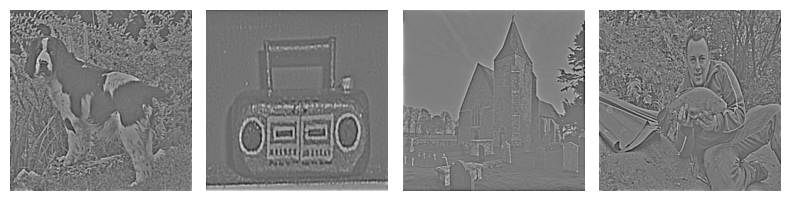

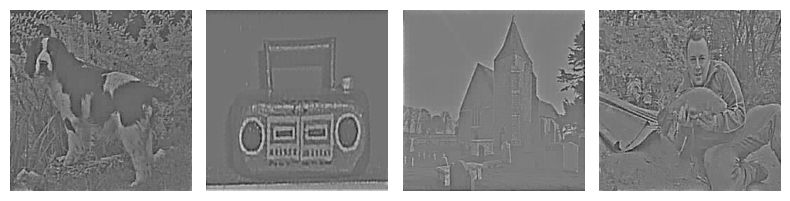

In [115]:
reconstructed_images = process_image_with_sparse_coding(imgs, dictionary, patch_size=8)

display_whitened_images(imgs)
display_images(reconstructed_images)

We can see that smaller patches lead to better reconstructions! And this should make sense given that each pattern is now responsible for less information.